# Import data

In [1]:

import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Flatten, Conv1D, Input, Dense, LSTM, Dropout, concatenate, Bidirectional, ConvLSTM2D, Reshape, Conv2D,MaxPooling2D
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ProgbarLogger, ModelCheckpoint
from sklearn.metrics import mean_squared_error, r2_score, median_absolute_error
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
from keras.models import Model
from sklearn.model_selection import train_test_split
from keras.utils.vis_utils import plot_model
import pickle
from sklearn.metrics import r2_score, mean_squared_error, median_absolute_error
!pip install visualkeras
import visualkeras

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.7/993.7 kB 26.1 MB/s eta 0:00:00


## Enable GPU

In [2]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    print("GPu not found")
  #raise SystemError('GPU device not found')

print('Found GPU at: {}'.format(device_name))

GPu not found
Found GPU at: 


In [3]:
'''tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)
strategy = tf.distribute.experimental.TPUStrategy(tpu)'''

'tpu = tf.distribute.cluster_resolver.TPUClusterResolver()\ntf.config.experimental_connect_to_cluster(tpu)\ntf.tpu.experimental.initialize_tpu_system(tpu)\nstrategy = tf.distribute.experimental.TPUStrategy(tpu)'

# Process Data
## Load in

In [4]:
mb_raw_data = pd.read_csv('/kaggle/input/mann-bruker/mann_bruker.txt', sep='\t')
mb_clean_frame = mb_raw_data[['Modified sequence', 'm/z', 'CCS','Mass','Charge','Length']]
mb_clean_frame = mb_clean_frame.groupby(['Modified sequence', 'Charge']).agg({'Mass':'median', 'CCS':'median','Length':'median'}).reset_index()
del mb_raw_data


mb_clean_frame['CCS_normalized'] = mb_clean_frame['CCS']
CCSscaler = StandardScaler()
mb_clean_frame['CCS_normalized'] = CCSscaler.fit_transform(mb_clean_frame[['CCS_normalized']])


encode_length = 52

mb_clean_frame = mb_clean_frame.sample(frac=1, random_state=1)

## Define One Hot Encoder, normalizer

In [5]:
def normalize(seq):
    seq = seq.replace('_', '')
    seq = seq.replace('(ac)', 'a')
    seq = seq.replace('M(ox)', 'm')
    return seq

    
def one_hot_encode(seq, encoding):
    mapping = dict(zip(encoding, range(len(encoding))))
    if isinstance(seq, int):
        seq = [seq]
    seq2 = [mapping[i] for i in seq]
    return np.eye(len(encoding))[seq2]


## Do one-hot encoding

In [6]:
# B = acetyl n-term, O Oxidation (M)
amino_acids = ['A', 'a', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'm', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y', 'U', 'X']
mb_clean_frame['Modified sequence normalized'] = mb_clean_frame['Modified sequence'].apply(normalize)
sequences = mb_clean_frame['Modified sequence normalized']

sequences = [list(seq[:encode_length].ljust(encode_length, 'X')) for seq in sequences]

one_hot_sequences = [one_hot_encode(seq, amino_acids) for seq in tqdm(sequences)]

mass_charge_length = mb_clean_frame[['Mass', 'Charge','Length']].values


mass_length_scaler = StandardScaler()
mass_length_scaled = mass_length_scaler.fit_transform(mass_charge_length)

y = mb_clean_frame['CCS_normalized'].values

100%|██████████| 236658/236658 [00:05<00:00, 47229.23it/s]


# Train Model
## Define splits, visualize

In [7]:
X_train_seq, X_test_seq, X_train_mc, X_test_mc, y_train, y_test = train_test_split(one_hot_sequences, mass_length_scaled, y, test_size=0.1, random_state=42)

one_hot_sequences_array = np.array(one_hot_sequences)
one_hot_sequences_array = one_hot_sequences_array.reshape(-1, encode_length, 24, 1)
#NAME MODEL
model_name = "CNN_32_64_128"

sequence_input_shape = (encode_length, 24, 1)  

sequence_input = Input(shape=sequence_input_shape, name="sequence_input")

mass_charge_input = Input(shape=(3,), name="mass_charge_input")

sequence_branch = Conv2D(64, (2, 2), activation='relu')(sequence_input)
sequence_branch = MaxPooling2D((2, 2))(sequence_branch)
sequence_branch = Conv2D(128, (2, 2), activation='relu')(sequence_branch)
sequence_branch = MaxPooling2D((2, 2))(sequence_branch)
sequence_branch = Flatten()(sequence_branch)

mass_charge_branch = Dense(16, activation="relu")(mass_charge_input)
mass_charge_branch = Dropout(0.2)(mass_charge_branch)
mass_charge_branch = Dense(8, activation="relu")(mass_charge_branch)


combined = concatenate([sequence_branch, mass_charge_branch])

z = Dense(64, activation="relu")(combined)
z = Dropout(0.2)(z)
z = Dense(32, activation="relu")(z)
z = Dropout(0.2)(z)

output = Dense(1, activation="linear", name="output")(z)


model = Model(inputs=[sequence_input, mass_charge_input], outputs=output)

initial_learning_rate = 0.001
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=12000,
    decay_rate=0.99,
    staircase=True)

optimizer = Adam()

model.compile(optimizer=optimizer, loss='huber', metrics=['mse'])

## Visualizekeras

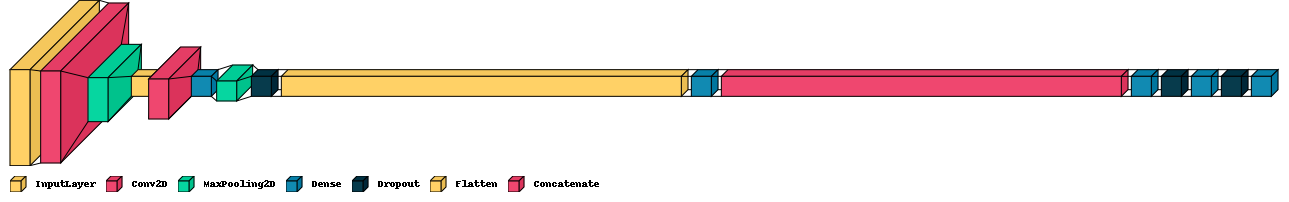

In [8]:
visualkeras.layered_view(model, legend=True)

## Vis2

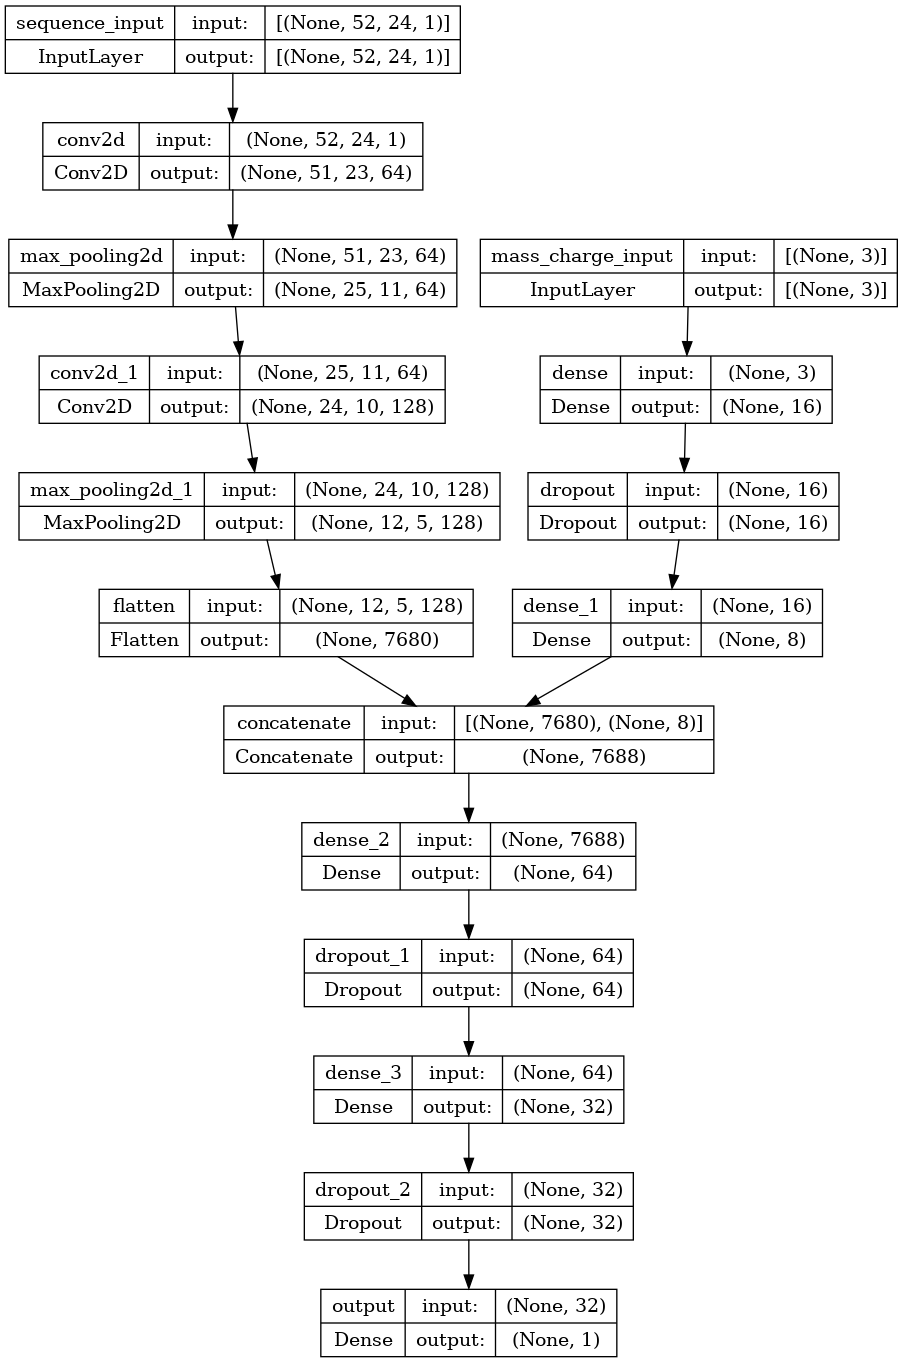

In [9]:
plot_model(model, show_shapes=True, show_layer_names=True)

## Train

In [10]:
patience = 10
batch_size = 32
epochs = 100
checkpoint = ModelCheckpoint((model_name+"_best_checkpoint.h5"), monitor='val_loss', verbose=1, save_best_only=True, mode='min')
early_stopping = EarlyStopping(monitor='val_loss', patience=patience)
progress_bar = ProgbarLogger(count_mode='steps', stateful_metrics=None)


history = model.fit([np.array(X_train_seq), np.array(X_train_mc)], np.array(y_train), validation_data=([np.array(X_test_seq), np.array(X_test_mc)], np.array(y_test)), batch_size=batch_size, epochs=epochs, callbacks=[checkpoint, early_stopping, progress_bar], verbose=1)

Epoch 1/100
6655/6656 [============================>.] - ETA: 0s - loss: 0.0270 - mse: 0.0551
Epoch 1: val_loss improved from inf to 0.00807, saving model to CNN_32_64_128_best_checkpoint.h5
6656/6656 [==============================] - 210s 31ms/step - loss: 0.0270 - mse: 0.0551 - val_loss: 0.0081 - val_mse: 0.0161
Epoch 2/100
6655/6656 [============================>.] - ETA: 0s - loss: 0.0168 - mse: 0.0338
Epoch 2: val_loss did not improve from 0.00807
6656/6656 [==============================] - 209s 31ms/step - loss: 0.0168 - mse: 0.0338 - val_loss: 0.0106 - val_mse: 0.0212
Epoch 3/100
6656/6656 [==============================] - ETA: 0s - loss: 0.0160 - mse: 0.0321
Epoch 3: val_loss did not improve from 0.00807
6656/6656 [==============================] - 209s 31ms/step - loss: 0.0160 - mse: 0.0321 - val_loss: 0.0118 - val_mse: 0.0237
Epoch 4/100
6656/6656 [==============================] - ETA: 0s - loss: 0.0158 - mse: 0.0318
Epoch 4: val_loss did not improve from 0.00807
6656/665

## Resume Training

In [11]:
'''X_train_seq, X_test_seq, X_train_mc, X_test_mc, y_train, y_test = train_test_split(one_hot_sequences, mass_charge_length_scaled, y, test_size=0.1, random_state=42)



model = tf.keras.models.load_model('LSTM_best_checkpoint.keras')


optimizer = Adam()
model.compile(optimizer=optimizer, loss='huber', metrics=['mse'])

patience = 15
batch_size = 32
epochs = 100
checkpoint = ModelCheckpoint((model_name+"_best_checkpoint.h5"), monitor='val_loss', verbose=1, save_best_only=True, mode='min')
early_stopping = EarlyStopping(monitor='val_loss', patience=patience)
progress_bar = ProgbarLogger(count_mode='steps', stateful_metrics=None)


history = model.fit([np.array(X_train_seq), np.array(X_train_mc)], np.array(y_train), validation_data=([np.array(X_test_seq), np.array(X_test_mc)], np.array(y_test)), batch_size=batch_size, epochs=epochs, callbacks=[checkpoint, early_stopping, progress_bar], verbose=1)'''

'X_train_seq, X_test_seq, X_train_mc, X_test_mc, y_train, y_test = train_test_split(one_hot_sequences, mass_charge_length_scaled, y, test_size=0.1, random_state=42)\n\n\n\nmodel = tf.keras.models.load_model(\'LSTM_best_checkpoint.keras\')\n\n\noptimizer = Adam()\nmodel.compile(optimizer=optimizer, loss=\'huber\', metrics=[\'mse\'])\n\npatience = 15\nbatch_size = 32\nepochs = 100\ncheckpoint = ModelCheckpoint((model_name+"_best_checkpoint.h5"), monitor=\'val_loss\', verbose=1, save_best_only=True, mode=\'min\')\nearly_stopping = EarlyStopping(monitor=\'val_loss\', patience=patience)\nprogress_bar = ProgbarLogger(count_mode=\'steps\', stateful_metrics=None)\n\n\nhistory = model.fit([np.array(X_train_seq), np.array(X_train_mc)], np.array(y_train), validation_data=([np.array(X_test_seq), np.array(X_test_mc)], np.array(y_test)), batch_size=batch_size, epochs=epochs, callbacks=[checkpoint, early_stopping, progress_bar], verbose=1)'

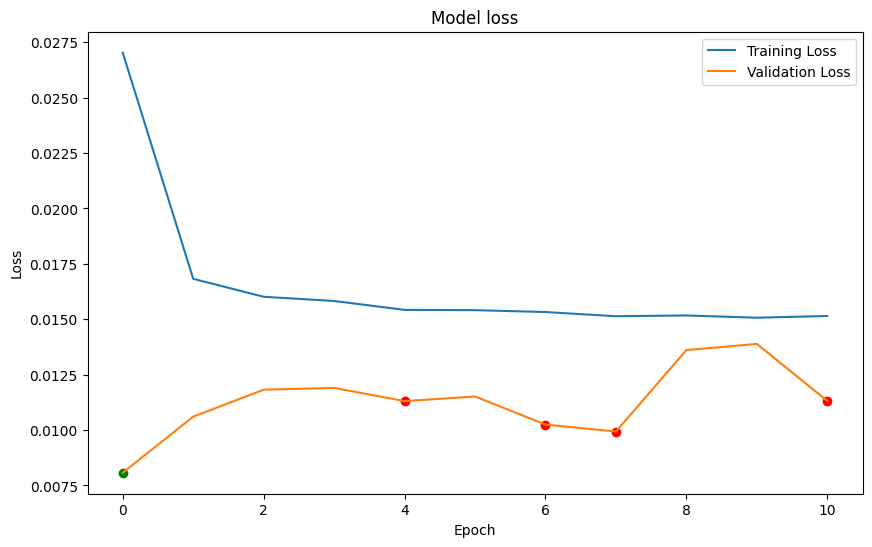

In [12]:

training_loss = history.history['loss']
validation_loss = history.history['val_loss']

# Find epochs where the validation loss decreased
min_val_loss_epochs = np.where(np.diff(validation_loss) < 0)[0] + 1

# Find epoch where the validation loss is minimum
best_val_loss_epoch = np.argmin(validation_loss)

plt.figure(figsize=(10, 6))
plt.plot(training_loss, label='Training Loss')
plt.plot(validation_loss, label='Validation Loss')

# Add a red dot
plt.scatter(min_val_loss_epochs, [validation_loss[i] for i in min_val_loss_epochs], color='red')

# Add a green dot
plt.scatter(best_val_loss_epoch, validation_loss[best_val_loss_epoch], color='green')

plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()


In [13]:

hist_df = pd.DataFrame(history.history)

# Save to json
hist_json_file = 'history.json'
with open(hist_json_file, mode='w') as f:
    hist_df.to_json(f)


Save the model and params

In [14]:

model.save((model_name+".h5"))



with open('model_params.pkl', 'wb') as f:
    pickle.dump({'CCS_scaler': CCSscaler, 'mass_length_scaler': mass_length_scaler}, f)

In [15]:
y_pred_test = model.predict([np.array(X_test_seq), np.array(X_test_mc)])

y_pred_test_orig = CCSscaler.inverse_transform(y_pred_test)


y_test = y_test.reshape(-1, 1) 
y_test_orig = CCSscaler.inverse_transform(y_test)

740/740 [==============================] - 7s 9ms/step


In [16]:
r2_test = r2_score(y_test_orig , y_pred_test_orig)
print(f"Test R^2: {r2_test}")

mse_test = mean_squared_error(y_test_orig , y_pred_test_orig)
print(f"Test MSE: {mse_test}")


Test R^2: 0.9773845109826959
Test MSE: 1.5026209425319198e-72


In [17]:
from sklearn.metrics import median_absolute_error

absolute_errors = np.abs(y_pred_test_orig - y_test_orig)

mae = median_absolute_error(y_test_orig, y_pred_test_orig)

mre = mae / np.median(y_test_orig)

print(f"Test MRE: {mre}")


Test MRE: 0.020184068575914177


/tmp/ipykernel_20/3158844750.py:2: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(y_test_orig, y_pred_test_orig, cmap='winter', alpha=0.2)


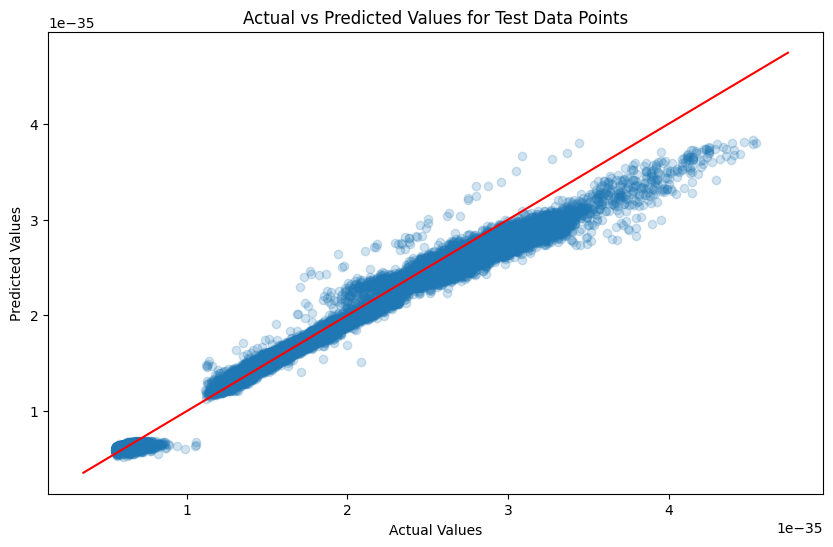

In [18]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test_orig, y_pred_test_orig, cmap='winter', alpha=0.2)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
limits = [np.min([plt.xlim(), plt.ylim()]),  # find the lower limit
          np.max([plt.xlim(), plt.ylim()])]  # find the upper limit
plt.plot(limits, limits, color='red')
plt.title('Actual vs Predicted Values for Test Data Points')
plt.show()

In [19]:
'''def predict_ccs(mass, charge, sequence):
    model = tf.keras.models.load_model((model_name+"_best_checkpoint.h5"))

    # Load the model parameters
    with open('model_params.pkl', 'rb') as f:
        params = pickle.load(f)
    CCS_scaler = params['CCS_scaler']
    mass_length_scaler = params['mass_length_scaler']

    # Normalize the sequence
    sequence = normalize(sequence)

    length = len(sequence)
    mass_charge_scaled = mass_length_scaler.transform(np.array([[mass, charge, length]]))
    
    sequence_encoded = one_hot_encode(sequence.ljust(encode_length, 'X'), amino_acids)
    sequence_encoded = np.array(sequence_encoded).reshape(-1, 52, 24, 1)

    ccs_z_pred = model.predict([sequence_encoded, mass_charge_scaled])

    # Reverse MinMax scaling
    ccs_pred = CCS_scaler.inverse_transform(ccs_z_pred)



    return ccs_pred[0][0]



# Test the function with some input values
mass = 3608.82972
charge = 3  
sequence = '_(ac)AAAFEASGALAAVATAM(ox)PAEHVAVQVPAPEPTPGPVR_'  

predicted_ccs = predict_ccs(mass, charge, sequence)
print(f"Predicted CCS: {predicted_ccs}")
print("Actual: " + "1.91993301213873E-35")'''


'def predict_ccs(mass, charge, sequence):\n    model = tf.keras.models.load_model((model_name+"_best_checkpoint.h5"))\n\n    # Load the model parameters\n    with open(\'model_params.pkl\', \'rb\') as f:\n        params = pickle.load(f)\n    CCS_scaler = params[\'CCS_scaler\']\n    mass_length_scaler = params[\'mass_length_scaler\']\n\n    # Normalize the sequence\n    sequence = normalize(sequence)\n\n    length = len(sequence)\n    mass_charge_scaled = mass_length_scaler.transform(np.array([[mass, charge, length]]))\n    \n    sequence_encoded = one_hot_encode(sequence.ljust(encode_length, \'X\'), amino_acids)\n    sequence_encoded = np.array(sequence_encoded).reshape(-1, 52, 24, 1)\n\n    ccs_z_pred = model.predict([sequence_encoded, mass_charge_scaled])\n\n    # Reverse MinMax scaling\n    ccs_pred = CCS_scaler.inverse_transform(ccs_z_pred)\n\n\n\n    return ccs_pred[0][0]\n\n\n\n# Test the function with some input values\nmass = 3608.82972\ncharge = 3  \nsequence = \'_(ac)AAAFEASG